In [467]:
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer, FunctionTransformer

from sklearn_pandas import DataFrameMapper 
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import make_pipeline

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

Populating the interactive namespace from numpy and matplotlib


### Part 1. Vancouver data 
scraped from Redfin.ca using scrape_van_20for6.py and data_dict.py

In [468]:
#load vancouver data:
data_v = "info_20.csv"
df_v = pd.read_csv(data_v)
df_v.head()

,Price,Beds,Baths,Size_sqft,Addr,Agent,MLS
0,"$849,000",2 Beds,1.5 Baths,958 Sq. Ft.,"2770 Burrard St #207, Vancouver, BC V6J 3J8",Redfin,MLS R2379412
1,"$448,000",1 Bed,1 Bath,592 Sq. Ft.,"3939 Knight St #101, Vancouver, BC V5N 3L8",Redfin,MLS R2395281
2,"$4,895,000",5 Beds,3.5 Baths,"3,682 Sq. Ft.","3878 W 11th Ave, Vancouver, BC V6R 2K9",RE/MAX Crest Realty,MLS R2410761
3,"$1,088,000",2 Beds,2 Baths,"1,075 Sq. Ft.","6633 Cambie St #305, Vancouver, BC V6P 0E5",Pacific Evergreen Realty Ltd.,MLS R2411150
4,"$4,480,000",6 Beds,5.5 Baths,"4,018 Sq. Ft.","1389 W 58th Ave, Vancouver, BC V6P 1W3",Sutton Group-West Coast Realty,MLS R2410938


In [469]:
#load vancouver data:
data_v = "info_20.csv"
df_v = pd.read_csv(data_v)
df_v.head()

,Price,Beds,Baths,Size_sqft,Addr,Agent,MLS
0,"$849,000",2 Beds,1.5 Baths,958 Sq. Ft.,"2770 Burrard St #207, Vancouver, BC V6J 3J8",Redfin,MLS R2379412
1,"$448,000",1 Bed,1 Bath,592 Sq. Ft.,"3939 Knight St #101, Vancouver, BC V5N 3L8",Redfin,MLS R2395281
2,"$4,895,000",5 Beds,3.5 Baths,"3,682 Sq. Ft.","3878 W 11th Ave, Vancouver, BC V6R 2K9",RE/MAX Crest Realty,MLS R2410761
3,"$1,088,000",2 Beds,2 Baths,"1,075 Sq. Ft.","6633 Cambie St #305, Vancouver, BC V6P 0E5",Pacific Evergreen Realty Ltd.,MLS R2411150
4,"$4,480,000",6 Beds,5.5 Baths,"4,018 Sq. Ft.","1389 W 58th Ave, Vancouver, BC V6P 1W3",Sutton Group-West Coast Realty,MLS R2410938


In [470]:
df_v.info() #data type: object, all have str and num mixed? clean further. No nulls in numerical columns though

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 7 columns):
Price        102 non-null object
Beds         102 non-null object
Baths        102 non-null object
Size_sqft    102 non-null object
Addr         102 non-null object
Agent        102 non-null object
MLS          99 non-null object
dtypes: object(7)
memory usage: 5.7+ KB


In [473]:
#use regular expressions to further clean data, and change numerical columns to ints or floats
import re
price = []
for item in df_v['Price']:
    item = re.sub(r'[^\w\s]','',item)
    price.append(int(item))  
    
beds_n = []
for item in df_v['Beds']:
    item = re.sub(r'[^\d\.]','',item) #replace anything that's not a digit or decimal point
    #print(item)
    if len(item) >0:
        beds_n.append(int(item))  
    else:
        item ==0
baths_n = []
for item in df_v['Baths']:
    item = re.sub(r'[^\d\.]','',item) #(^\d is the same as \D)
    #print((item))
    if len(item) >0: #without this condition, get error b/c can't turn empty string into float
        baths_n.append(float(item))   
    else:
        item ==0
        
size_sqft = []
for item in df_v['Size_sqft']:
    item = re.sub(r'[^\d]','',item) 
    #print(item)
    if len(item) >0:
        size_sqft.append(int(item))  
    else:
        item ==0

In [474]:
#make smaller dataframe from cleaned lists of data
df_vsm = pd.DataFrame(list(zip(price, beds_n, baths_n, size_sqft)),
              columns=['price','beds_n', 'baths_n', 'size_sqft'])
df_vsm.sample()

,price,beds_n,baths_n,size_sqft
2,4895000,5,3.5,3682


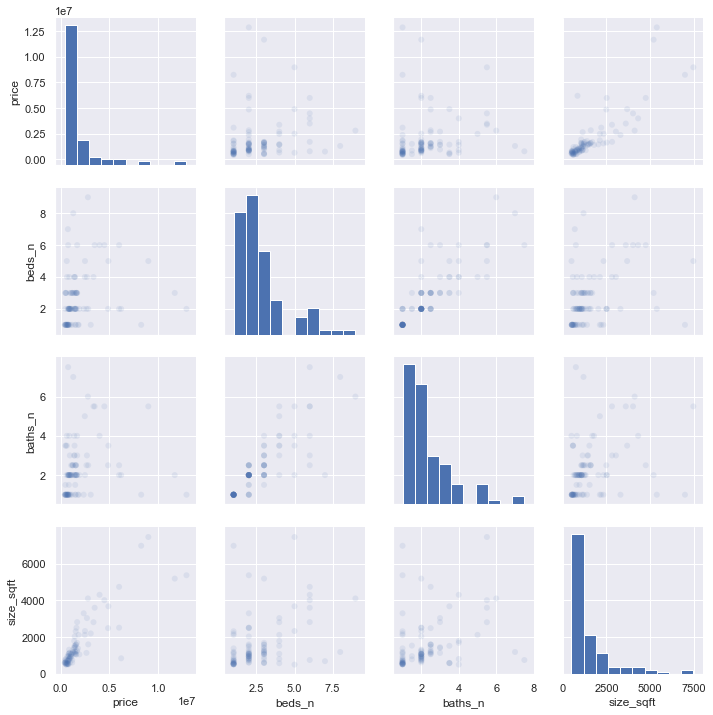

In [475]:
#pairplot of relationship between each of the numerical features and target (price)
sns.pairplot(df_vsm, plot_kws=dict(alpha=.1, edgecolor='none'));

Here we see price does seem to have a relationship with size, but it's relationship with number of bedrooms and bathrooms is less clear. Also those features could be correlated.

In [478]:
#Price column has outliers, do a log transformation on the Price data to make the distribution look more Gaussian
price_lg = np.log(price)
#later need to take exp of price before getting MSE (can also do log 10 -- base of log doesn't matter) 

#use the log of the price in df for modelling
df_vlg = pd.DataFrame(list(zip(price_lg, beds_n, baths_n, size_sqft)),
              columns=['price(log)','beds_n', 'baths_n', 'size_sqft'])
df_vlg.head()

,price(log),beds_n,baths_n,size_sqft
0,13.651814,2,1.5,958
1,13.012549,1,1.0,592
2,15.403725,5,3.5,3682
3,13.899852,2,2.0,1075
4,15.315134,6,5.5,4018


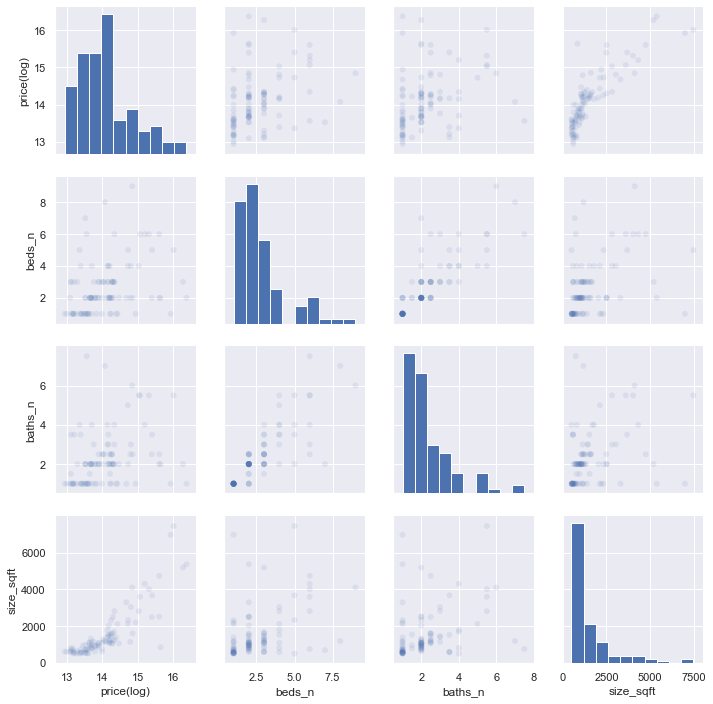

In [479]:
#pairplot on Vancouver dataset to observe relationship between each feature and target (price)
sns.pairplot(df_vlg, plot_kws=dict(alpha=.1, edgecolor='none'));

The relationship between size and price seems the most clear, could also be curving upwards (quadratic? -- this suggests adding polynomial terms or transformations later)

In [480]:
#Separate features from our target (prevent accidentally bringing in y as predictor);

Xv = df_vlg.loc[:,['beds_n','baths_n','size_sqft']]#vancouver data does not have "days on market" info
yv = df_vlg['price(log)']


#Feature scaling for train and test 
scaler = StandardScaler()

#test-train 80-20 split, seed it so get exact same result over mult runs
Xv_train, Xv_test, yv_train, yv_test = train_test_split(Xv, yv, test_size=0.2, random_state=42) #can get overfitting with diff random state

Xv_train_scaled = scaler.fit_transform(Xv_train.values)
Xv_test_scaled = scaler.transform(Xv_test.values)

#set up linear regression model
lm = LinearRegression()
lm.fit(Xv_train_scaled, yv_train)
print(f'Linear Regression train R^2: {lm.score(Xv_train_scaled, yv_train):.3f}') 

Linear Regression train R^2: 0.688


In [481]:
lm.fit(Xv_test_scaled,yv_test)
print(f'Linear Regression test R^2: {lm.score(Xv_test_scaled, yv_test):.3f}')

Linear Regression test R^2: 0.919


From sklearn documentation, definition of metric R^2:
> The coefficient R^2 is defined as (1 - u/v), where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum(). The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 

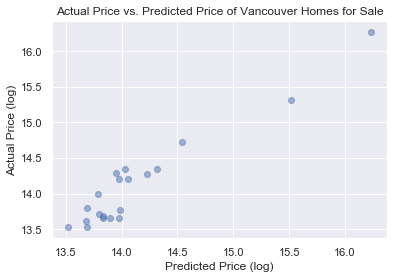

In [482]:
v_lm_pred = lm.predict(Xv_test_scaled)

#plot of y-actual vs. y-predicted 
plt.scatter(v_lm_pred, yv_test, alpha=.5);
plt.title('Actual Price vs. Predicted Price of Vancouver Homes for Sale');
plt.xlabel('Predicted Price (log)');
plt.ylabel('Actual Price (log)');

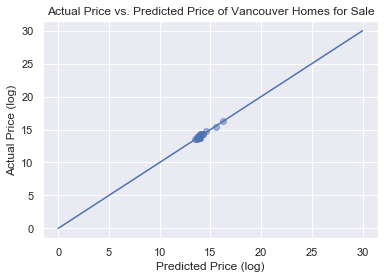

In [483]:
plt.scatter(v_lm_pred, yv_test, alpha=.5);
plt.title('Actual Price vs. Predicted Price of Vancouver Homes for Sale');
plt.xlabel('Predicted Price (log)');
plt.ylabel('Actual Price (log)');
plt.plot(np.linspace(0,30), np.linspace(0,30));

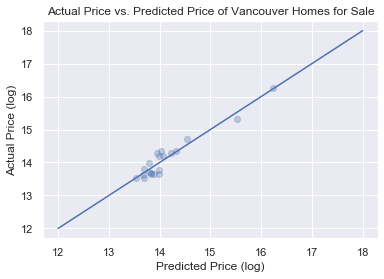

In [484]:
#zoom in
plt.scatter(v_lm_pred, yv_test, alpha=.3);
plt.title('Actual Price vs. Predicted Price of Vancouver Homes for Sale');
plt.xlabel('Predicted Price (log)');
plt.ylabel('Actual Price (log)');
plt.plot(np.linspace(12,18), np.linspace(12,18));

#mvp with Vancouver (scraped) data, smaller dataset but seems to give good fit after log transform and scaling

--------

#### Cross-validate on Vancouver dataset to get more reliable R^2

In [485]:
  from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

#Using Xv and yv defined previously, after log-transform of price(y):
#Xv = df_vlg.loc[:,['beds_n','baths_n','size_sqft']]#vancouver data does not have "days on market" info
#yv = df_vlg['price(log)']

#make into arrays, helps with the way kf will generate indices below
Xva, yva = np.array(Xv), np.array(yv)  
cross_val_score(lm, Xva, yva, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([0.7660308 , 0.51129001, 0.79214381, 0.76839344, 0.4974521 ])

In [487]:
cross_val_score(lm, Xva, yva, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric


array([0.7660308 , 0.51129001, 0.79214381, 0.76839344, 0.4974521 ])

In [489]:
#average of cross_val_scores of all folds
v_lm_meanr2=np.mean(cross_val_score(lm, Xva, yva, cv=5, scoring='r2'))
print(v_lm_meanr2)

0.6670620306077402


In [490]:
#use a diffent method in order to display training R^2 scores also:

cv_lm_scores = cross_validate(lm, Xva, yva, cv=5,
                        scoring=('r2'), #can calculate other types of metrics also
                        return_train_score=True)
sorted(cv_lm_scores.keys())#['fit_time', 'score_time', 'test_score', 'train_score']

print('Linear model train r2: ', cv_lm_scores['train_score'])     

print('Linear model test r2: ', cv_lm_scores['test_score'])    

print('Linear model, mean train r2:', np.mean(cv_lm_scores['train_score']))

print('Linear model, mean test r2:', np.mean(cv_lm_scores['test_score']))

Linear model train r2:  [0.7025598  0.74770458 0.68738897 0.69933848 0.76821454]
Linear model test r2:  [0.7660308  0.51129001 0.79214381 0.76839344 0.4974521 ]
Linear model, mean train r2: 0.7210412743199385
Linear model, mean test r2: 0.6670620306077402


So for the Vancouver dataset, using the linear regression model and standard scaler, our test r2 score averaged over 5 folds is 0.667, while average train r2 is 0.721. This shows we are overfitting.

Because it is already overfitting with the simple linear model, won't go to polynomials with cv. 

But first try different scalers before doing regularization:

#### Applying different scaling transformations to standardize data

Notes from sklearn documentation, on scalers other than StandardScaler to standardize data:

> StandardScaler removes the mean and scales the data to unit variance. However, the outliers have an influence when computing the empirical mean and standard deviation which shrink the range of the feature values

> MinMaxScaler rescales the data set such that all feature values are in the range [0, 1]. However, this scaling compress all inliers in the narrow range [0, 0.005] for the transformed number of households. As StandardScaler, MinMaxScaler is very sensitive to the presence of outliers.

> RobustScaler is based on percentiles and are therefore not influenced by a few number of very large marginal outliers.

> QuantileTransformer provides non-linear transformations in which distances between marginal outliers and inliers are shrunk. It has an additional output_distribution parameter allowing to match a Gaussian distribution instead of a uniform distribution. Note that this non-parametetric transformer introduces saturation artifacts for extreme values.

> PowerTransformer provides non-linear transformations in which data is mapped to a normal distribution to stabilize variance and minimize skewness. PowerTransformer applies a power transformation to each feature to make the data more Gaussian-like. Currently, PowerTransformer implements the Yeo-Johnson and Box-Cox transforms. Note that Box-Cox can only be applied to strictly positive data. Income and number of households happen to be strictly positive.

In [491]:
def scales(scalertype, dfx):
    '''Takes in a scaler type and a dataframe of data that needs to be scaled.
    Input scalertype needs to be in the format of "RobustScaler()""
    Returns array of scaled data.'''
    scaler = scalertype
    X_scaled = scaler.fit_transform(dfx.values)
    return X_scaled
#scaledx=scales(StandardScaler(), Xv)

In [492]:
#scale X values in Xv from Vancouver dataframe using scalers noted above
X_minmax=scales(MinMaxScaler(), Xv)
X_robust=scales(RobustScaler(), Xv)
X_quant=scales(QuantileTransformer(), Xv)
X_power=scales(PowerTransformer(), Xv)

#*a better alternative might be to transform select columns in X only (with DataFrameMapper?); but ran out of time

/Library/anaconda/envs/metis/lib/python3.7/site-packages/sklearn/preprocessing/data.py:2239: UserWarning: n_quantiles (1000) is greater than the total number of samples (100). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


#### Cross validation

In [493]:
#now feed scaled data into cv with 5 folds

cv_lm_scores = cross_validate(lm, X_minmax, yva, cv=5,
                        scoring=('r2'), #can calculate other types of metrics also
                        return_train_score=True)
sorted(cv_lm_scores.keys())#['fit_time', 'score_time', 'test_score', 'train_score']

print('Linear model, minmax scaled, train r2: ', cv_lm_scores['train_score'])     
print('Linear model, minmax scaled, mean train r2:', np.mean(cv_lm_scores['train_score']))
print('Linear model, minmax scaled, test r2: ', cv_lm_scores['test_score'])  
print('Linear model, minmax scaled, mean test r2:', np.mean(cv_lm_scores['test_score']))

Linear model, minmax scaled, train r2:  [0.7025598  0.74770458 0.68738897 0.69933848 0.76821454]
Linear model, minmax scaled, mean train r2: 0.7210412743199385
Linear model, minmax scaled, test r2:  [0.7660308  0.51129001 0.79214381 0.76839344 0.4974521 ]
Linear model, minmax scaled, mean test r2: 0.6670620306077479


In [494]:
cv_lm_scores = cross_validate(lm, X_robust, yva, cv=5,
                        scoring=('r2'), #can calculate other types of metrics also
                        return_train_score=True)
sorted(cv_lm_scores.keys())#['fit_time', 'score_time', 'test_score', 'train_score']

print('Linear model, robust scaled, train r2: ', cv_lm_scores['train_score'])     
print('Linear model, robust scaled, mean train r2:', np.mean(cv_lm_scores['train_score']))
print('Linear model, robust scaled, test r2: ', cv_lm_scores['test_score'])  
print('Linear model, robust scaled, mean test r2:', np.mean(cv_lm_scores['test_score']))

Linear model, robust scaled, train r2:  [0.7025598  0.74770458 0.68738897 0.69933848 0.76821454]
Linear model, robust scaled, mean train r2: 0.7210412743199384
Linear model, robust scaled, test r2:  [0.7660308  0.51129001 0.79214381 0.76839344 0.4974521 ]
Linear model, robust scaled, mean test r2: 0.6670620306077482


In [495]:
cv_lm_scores = cross_validate(lm, X_quant, yva, cv=5,
                        scoring=('r2'), #can calculate other types of metrics also
                        return_train_score=True)
sorted(cv_lm_scores.keys())#['fit_time', 'score_time', 'test_score', 'train_score']

print('Linear model, quant scaled, train r2: ', cv_lm_scores['train_score'])     
print('Linear model, quant scaled, mean train r2:', np.mean(cv_lm_scores['train_score']))
print('Linear model, quant scaled, test r2: ', cv_lm_scores['test_score'])  
print('Linear model, quant scaled, mean test r2:', np.mean(cv_lm_scores['test_score']))

Linear model, quant scaled, train r2:  [0.64868177 0.69804398 0.65157859 0.67828449 0.77379947]
Linear model, quant scaled, mean train r2: 0.6900776575509727
Linear model, quant scaled, test r2:  [0.8437277  0.59789129 0.79504886 0.69222764 0.32672882]
Linear model, quant scaled, mean test r2: 0.6511248638865459


In [496]:
cv_lm_scores = cross_validate(lm, X_power, yva, cv=5,
                        scoring=('r2'), #can calculate other types of metrics also
                        return_train_score=True)
sorted(cv_lm_scores.keys())#['fit_time', 'score_time', 'test_score', 'train_score']

print('Linear model, power scaled, train r2: ', cv_lm_scores['train_score'])     
print('Linear model, power scaled, mean train r2:', np.mean(cv_lm_scores['train_score']))
print('Linear model, power scaled, test r2: ', cv_lm_scores['test_score'])  
print('Linear model, power scaled, mean test r2:', np.mean(cv_lm_scores['test_score']))

Linear model, power scaled, train r2:  [0.68897113 0.72981331 0.68570149 0.71456806 0.79994026]
Linear model, power scaled, mean train r2: 0.7237988541174845
Linear model, power scaled, test r2:  [0.85350541 0.65593992 0.8324746  0.72417081 0.41416836]
Linear model, power scaled, mean test r2: 0.6960518189826141


Using the PowerScaler Box-Cox transform on the cross-validated linear model, we get a higher mean test r2 (0.696 vs 0.667 for standardscaler). According to the documentation, this scaler uses the Box-Cox method to make data more Gaussian like (Box-Cox only works for positive values, which is fine for our housing data set).

We will use the PowerScaler and the Linear Model going forward, and apply regularization to this Vancouver dataset to adjust for overfitting


#### Regularization - Ridge or Lasso?

In [524]:
#lasso, PowerScaler
lr_model_lasso = Lasso(alpha = 0.05)  #lasso coefficients ~0 for alpha > 1? is it due to power scaler or log transform?
lr_model_lasso.fit(X_power, yva)

list(zip(Xv.columns, lr_model_lasso.coef_))

[('beds_n', 0.0), ('baths_n', 0.0), ('size_sqft', 0.5878966220817612)]

Lasso chooses size as the most important feature, throws away other features. 

In [525]:
print(f'Lasso test R^2: {lr_model_lasso.score(X_power, yva):.3f}') 
#Returns the coefficient of determination R^2 of the prediction

Lasso test R^2: 0.715


In [526]:
#ridge regularization, powerscaler
lr_model_ridge = Ridge(alpha = 100)  #ridge smoothes out coeffs and brings them closer to 0, so small coefficients are ok
lr_model_ridge.fit(X_power, yva) 

list(zip(Xv.columns, lr_model_ridge.coef_))

[('beds_n', 0.05275144910911493),
 ('baths_n', 0.03921148634894221),
 ('size_sqft', 0.29891807966151246)]

In [527]:
print(f'Ridge test R^2: {lr_model_ridge.score(X_power, yva):.3f}') 
#Returns the coefficient of determination R^2 of the prediction

Ridge test R^2: 0.546


In [528]:
#ridge regularization, powerscaler
lr_model_ridge = Ridge(alpha = 10)  #ridge smoothes out coeffs and brings them closer to 0, so small coefficients are ok
lr_model_ridge.fit(X_power, yva) 

list(zip(Xv.columns, lr_model_ridge.coef_))

[('beds_n', 0.020687878460195652),
 ('baths_n', -0.006720027807836528),
 ('size_sqft', 0.5739838501109626)]

In [529]:
print(f'Ridge test R^2: {lr_model_ridge.score(X_power, yva):.3f}') 
#Returns the coefficient of determination R^2 of the prediction

Ridge test R^2: 0.713


Lasso regularization discarded features we wanted. We don't have enough features to justify throwing anything away. Ridge seems to be the better option here. And when alpha is smaller, R^2 for both regularization methods are more similar.

Also there is some randomness in previous r2 scores, now compare R2 for the two models after cv

In [603]:
#Ridge regression
cv_r_scores = cross_validate(lr_model_ridge, X_power, yva, cv=5,
                        scoring=('r2'), #can calculate other types of metrics also
                        return_train_score=True)
#sorted(cv_lm_scores.keys())#['fit_time', 'score_time', 'test_score', 'train_score']

print('ridge, train r2: ', cv_r_scores['train_score'])     
print('ridge, mean train r2:', np.mean(cv_r_scores['train_score']))
print('ridge, test r2: ', cv_r_scores['test_score'])  
print('ridge, mean test r2:', np.mean(cv_r_scores['test_score']))
#get higher r2 for ridge using standard/robust scalers*

ridge, train r2:  [0.67936981 0.72081586 0.67482652 0.70467659 0.78144613]
ridge, mean train r2: 0.712226982014289
ridge, test r2:  [0.84082177 0.64832132 0.8272384  0.67096317 0.50432372]
ridge, mean test r2: 0.6983336750121873


In [605]:
#Lasso regression
cv_l_scores = cross_validate(lr_model_lasso, X_power, yva, cv=5,
                        scoring=('r2'), #can calculate other types of metrics also
                        return_train_score=True)
sorted(cv_lm_scores.keys())#['fit_time', 'score_time', 'test_score', 'train_score']

print('Lasso, train r2: ', cv_l_scores['train_score'])     
print('Lasso, mean train r2:', np.mean(cv_l_scores['train_score']))
print('Lasso, test r2: ', cv_l_scores['test_score'])  
print('Lasso, mean test r2:', np.mean(cv_l_scores['test_score']))

Lasso, train r2:  [0.68294846 0.72473854 0.68023532 0.71037737 0.78420638]
Lasso, mean train r2: 0.716501215174602
Lasso, test r2:  [0.85019724 0.66049922 0.84313642 0.70154779 0.50716758]
Lasso, mean test r2: 0.7125096513345435


After cv, Lasso still gives better r2 scores, and is not as overfitted

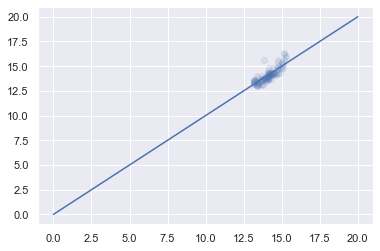

In [619]:
#We will now plot actual vs predicted price for both -- without cv first
ridge_pred = lr_model_ridge.predict(X_power)

plt.scatter(ridge_pred, yva, alpha=.1)
plt.plot(np.linspace(0,20), np.linspace(0,20));

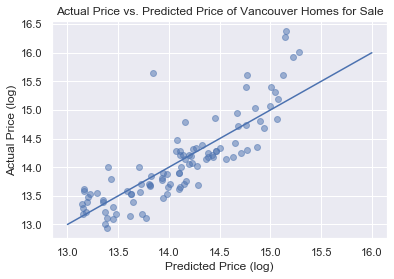

In [625]:
#plot of y-actual vs. y-predicted after ridge regularization, zoomed in
plt.scatter(ridge_pred, yva, alpha=.5);
plt.title('Actual Price vs. Predicted Price of Vancouver Homes for Sale');
plt.xlabel('Predicted Price (log)');
plt.ylabel('Actual Price (log)');
plt.plot(np.linspace(13,16), np.linspace(13,16));
plt.savefig('vanlogridge1.png')

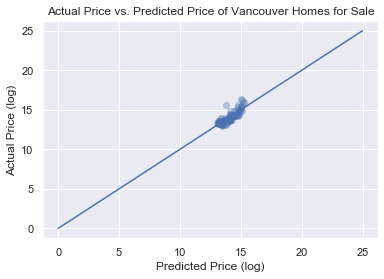

In [626]:
#now we plot actual vs predicted y values after cv for each of the regularization models

#ridge -- with cv
ridge = Ridge(alpha = 10) 
ridge.fit(Xva, yva)
yv_pred_r = cross_val_predict(ridge, X_power, yv, cv=5)

#plot of y-actual vs. y-predicted after ridge regularization, for regularization alpha(lambda) = 1
plt.scatter(yv_pred_r, yv, alpha=.3);
plt.title('Actual Price vs. Predicted Price of Vancouver Homes for Sale');
plt.xlabel('Predicted Price (log)');
plt.ylabel('Actual Price (log)');
plt.plot(np.linspace(0,25), np.linspace(0,25));

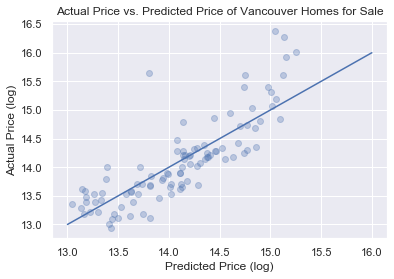

In [627]:
#zoomed in
plt.scatter(yv_pred_r, yv, alpha=.3);
plt.title('Actual Price vs. Predicted Price of Vancouver Homes for Sale');
plt.xlabel('Predicted Price (log)');
plt.ylabel('Actual Price (log)');
plt.plot(np.linspace(13,16), np.linspace(13,16));
plt.savefig('vanlogridgecv1.png')

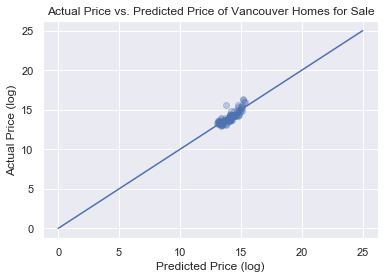

In [644]:
#lasso -- with cv
lasso = Lasso(alpha = 0.05) 
lasso.fit(Xva, yva)
yv_pred_r = cross_val_predict(lasso, X_power, yv, cv=5) #use Xv for standardscaler

#plot of y-actual vs. y-predicted after ridge regularization, for regularization alpha(lambda) = 1
plt.scatter(yv_pred_r, yv, alpha=.3);
plt.title('Actual Price vs. Predicted Price of Vancouver Homes for Sale');
plt.xlabel('Predicted Price (log)');
plt.ylabel('Actual Price (log)');
plt.plot(np.linspace(0,25), np.linspace(0,25));

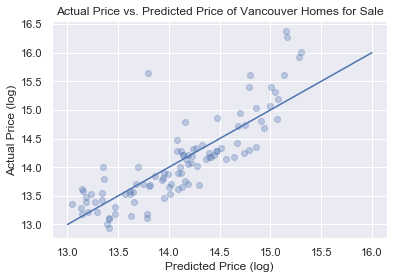

In [646]:
plt.scatter(yv_pred_r, yv, alpha=.3);
plt.title('Actual Price vs. Predicted Price of Vancouver Homes for Sale');
plt.xlabel('Predicted Price (log)');
plt.ylabel('Actual Price (log)');
plt.plot(np.linspace(13,16), np.linspace(13,16));
plt.savefig('vanloglassocv.png')
#plt.savefig('vanloglassocv.svg') not supported by keynote on my computer

As expected for two models giving very similar r2 and data scaled the same way, the plots for ridge and lasso at these particular alphas are very similar

In [569]:
#Next we want to undo log transform on target feature (price) to find RMSE in units of Dollars (more realistic)
#undo log transform on y

y_new = np.exp(yva)

In [631]:
#Ridge regression, y in dollars
cv_r_scores = cross_validate(ridge, X_power, y_new, cv=5,
                        scoring=('r2', 'neg_mean_squared_error'), #can calculate other types of metrics also
                        return_train_score=True)

print('Ridge, mean train r2:', np.mean(cv_r_scores['train_r2']))
print('Ridge, mean test r2:', np.mean(cv_r_scores['test_r2']), '\n')

print('average train mse:', -(np.mean(cv_r_scores['train_neg_mean_squared_error'])))
print('average test mse', -(np.mean(cv_r_scores['test_neg_mean_squared_error'])), '\n')

print('ridge RMSE', np.sqrt(-(np.mean(cv_r_scores['test_neg_mean_squared_error']))))


Ridge, mean train r2: 0.47031078419934
Ridge, mean test r2: 0.46588969694063775 

average train mse: 2503922876170.616
average test mse 2836761295275.464 

ridge RMSE 1684268.771685643


In [632]:
#Lasso regression, y in dollars
cv_la_scores = cross_validate(lasso, X_power, y_new, cv=5,
                        scoring=('r2','neg_mean_squared_error'), #can calculate other types of metrics also
                        return_train_score=True)

print('Lasso, mean train r2:', np.mean(cv_la_scores['train_r2']))
print('Lasso, mean test r2:', np.mean(cv_la_scores['test_r2']), '\n')

print('Lasso mean train mse:', -(np.mean(cv_la_scores['train_neg_mean_squared_error'])))
print('Lasso mean test mse', -(np.mean(cv_la_scores['test_neg_mean_squared_error'])), '\n')

print('Lasso RMSE', np.sqrt(-(np.mean(cv_la_scores['test_neg_mean_squared_error']))))

Lasso, mean train r2: 0.4824976947433736
Lasso, mean test r2: 0.4363462583208514 

Lasso mean train mse: 2449663697128.163
Lasso mean test mse 2982608426709.5527 

Lasso RMSE 1727022.995420024


After undoing log transform on y, r2 decreases, but ridge performs better (not as overfitting).
There seems to be some scaling issue with the huge mse value. Or the model could be really biased. I would look into this first before trying to improve the model.

One other option to try is to plot residuals, look for patterns indicating our linear model was too simple (didn't start with this because saw overfitting with linear model).

The next step for this dataset (after getting more Vancouver data, probably from a different website) would be to perform feature engineering and regularize to see if we can improve r2.

---------

----------

#### But wait, there's more! Seattle dataset has more rows and features:

### Part 2. Seattle data

In [4]:
#load seattle data:
data_sea = "redfin_seattle_18p.csv"
df_s = pd.read_csv(data_sea)

In [5]:
df_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 27 columns):
SALE TYPE                                                                                     350 non-null object
SOLD DATE                                                                                     0 non-null float64
PROPERTY TYPE                                                                                 350 non-null object
ADDRESS                                                                                       350 non-null object
CITY                                                                                          350 non-null object
STATE OR PROVINCE                                                                             350 non-null object
ZIP OR POSTAL CODE                                                                            350 non-null int64
PRICE                                                                                         350 n

The number of non-null entries are not all 350, indicating some listings have null values for those features


In [7]:
##need to drop NAs to make pairplot 
df_s_dropallnas = df_s.replace(np.nan, 0) 
#replaced NAs with 0; alternative is to drop these rows but we have a small dataset*

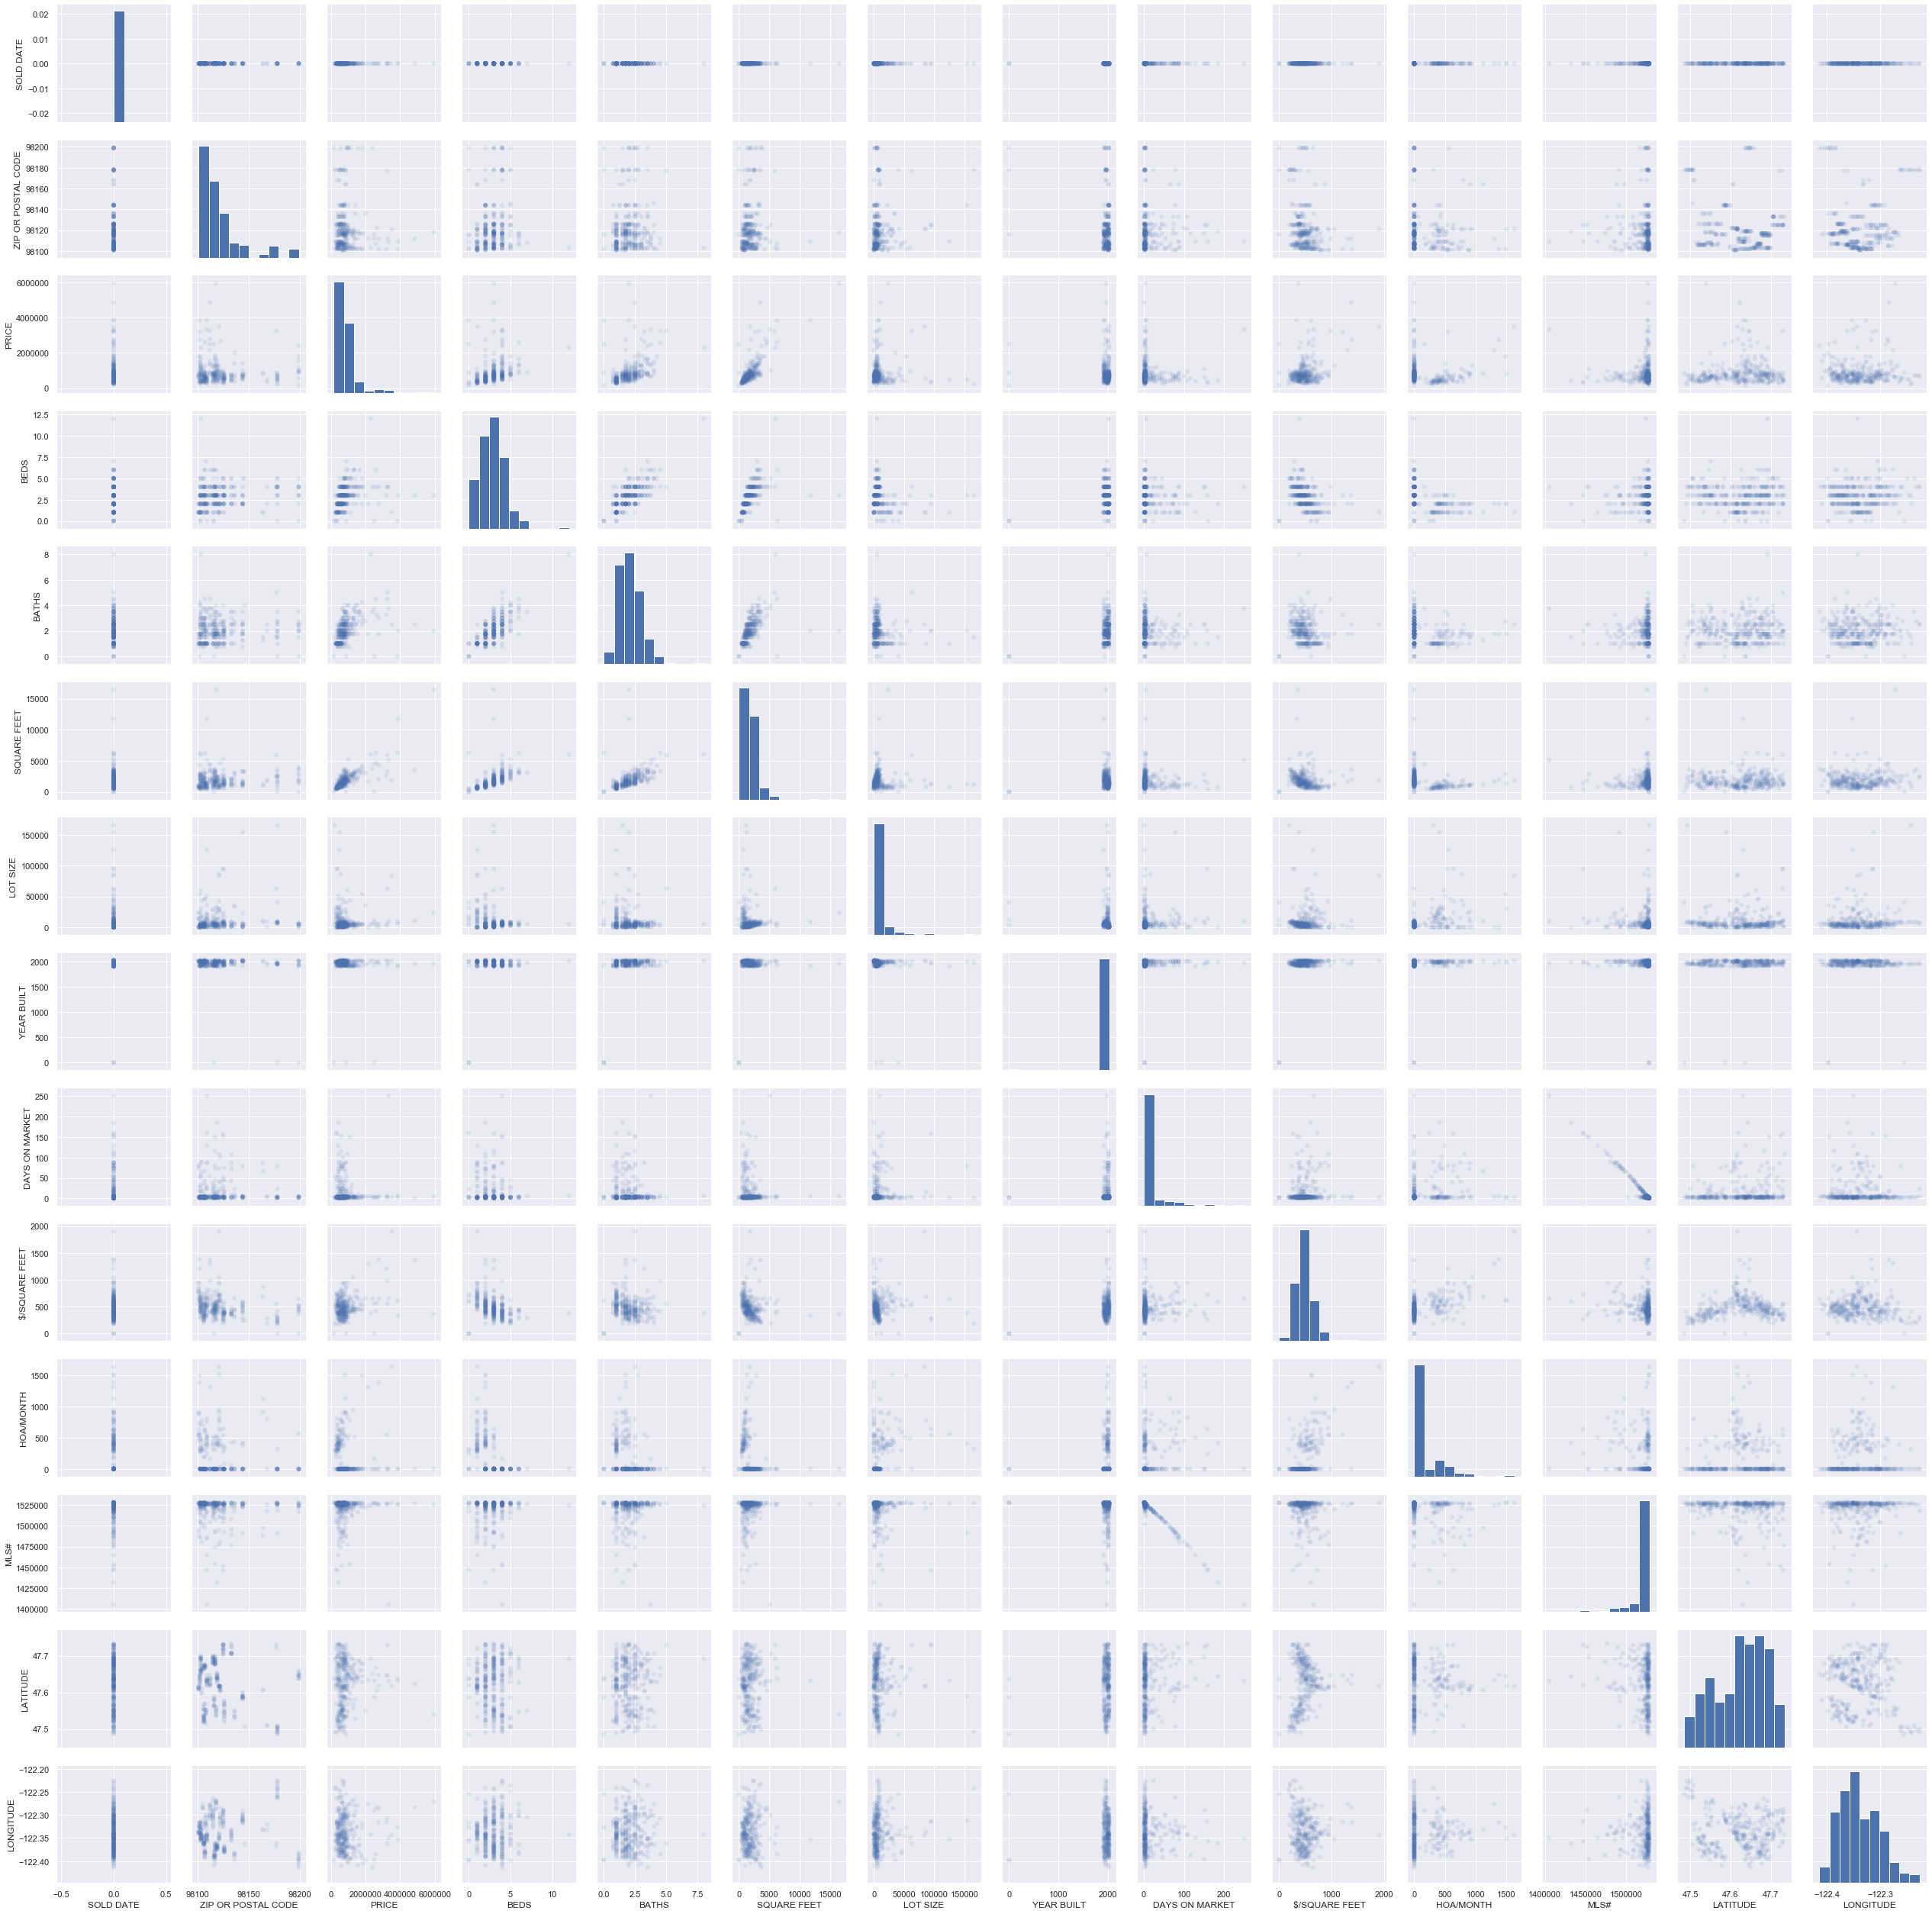

In [8]:
sns.pairplot(df_s_dropallnas, plot_kws=dict(alpha=.1, edgecolor='none'));

From the pairplot above, we see price is likely to have a linear relationship with beds, baths, and sqft.
It also looks like some variables could be correlated (Beds and baths, beds and square feet) or interacting - likely to have overfitting

In [10]:
#Do a log transformation on the Price data to make the distribution look more Gaussian
price_lg = np.log(df_s_dropallnas['PRICE'])
price_lg.head()
#need to take exp of price before getting MSE?** take exp? (or both log 10 -- base of log doesn't matter) 
#transforming data ~mult by const

0    12.524345
1    12.765688
2    12.981951
3    13.081541
4    13.610943
Name: PRICE, dtype: float64

In [11]:
df_slg = pd.DataFrame(list(zip(price_lg, df_s_dropallnas['BEDS'],df_s_dropallnas['BATHS'],df_s_dropallnas['SQUARE FEET'],df_s_dropallnas['DAYS ON MARKET'])),
              columns=['price(log)','beds', 'baths', 'size_sqft','days_listed'])
df_slg.head()

,price(log),beds,baths,size_sqft,days_listed
0,12.524345,1,1.0,546.0,2
1,12.765688,3,1.0,1000.0,2
2,12.981951,1,1.0,791.0,2
3,13.081541,4,1.5,1900.0,2
4,13.610943,1,1.5,1142.0,2


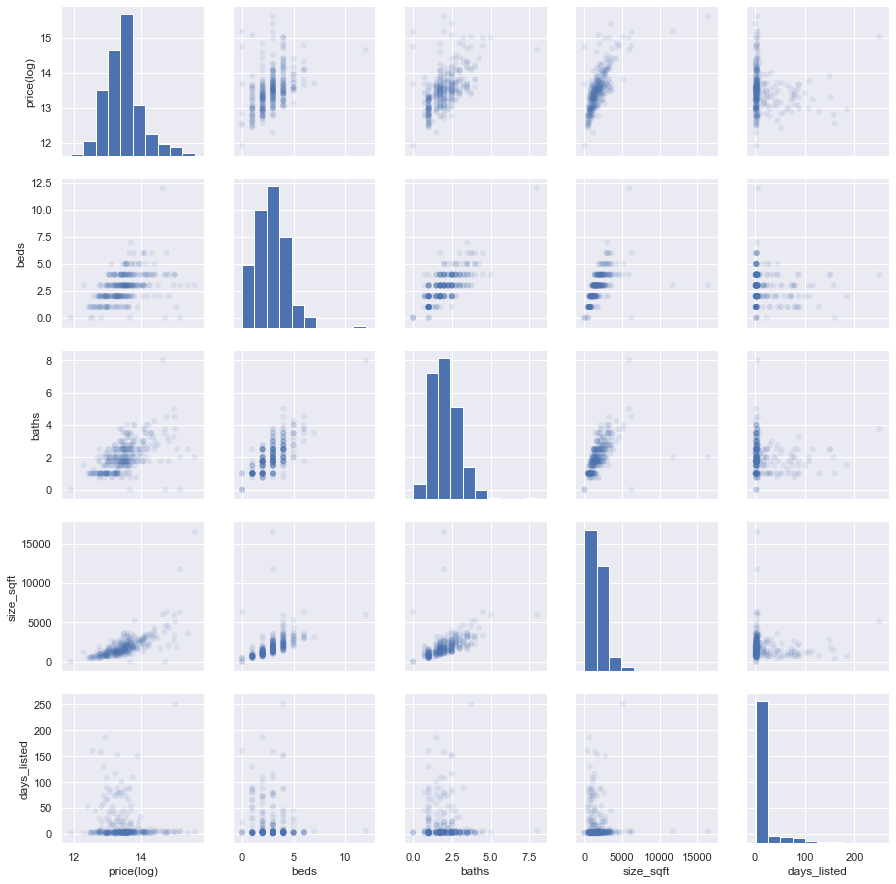

In [553]:
#do another pairplot, this time using log-transformed data and smaller df of numerical features,
#to see if we see any non-linear behaviours that could suggest adding polynomial terms or transformations to those features
sns.pairplot(df_slg, plot_kws=dict(alpha=.1, edgecolor='none'));

In [12]:
#Separate features from our target (prevent accidentally bringing in y as predictor);
#focus on numerical features that appear to have some correlation with price
#using columns that have all NAs replaced by 0

Xs = df_slg.loc[:,['beds', 'baths', 'size_sqft','days_listed']]

ys = df_slg['price(log)']

In [13]:
Xs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 4 columns):
beds           350 non-null int64
baths          350 non-null float64
size_sqft      350 non-null float64
days_listed    350 non-null int64
dtypes: float64(2), int64(2)
memory usage: 11.1 KB


Start with a simple linear regression model, standardizing data using the StandardScaler

In [14]:
#Feature scaling for train and test 
scaler = StandardScaler()

#test-train 80-20 split, seed it so get exact same result over multiple runs
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, test_size=0.2, random_state=66)# if random=42, trainR2=0.630. test=0.392?

Xs_train_scaled = scaler.fit_transform(Xs_train.values)
Xs_test_scaled = scaler.transform(Xs_test.values)

In [15]:
#set up linear regression model
lm = LinearRegression()
lm.fit(Xs_train_scaled, ys_train)
print(f'Linear Regression train R^2: {lm.score(Xs_train_scaled, ys_train):.3f}') 

Linear Regression train R^2: 0.533


In [16]:
lm.fit(Xs_test_scaled,ys_test)
print(f'Linear Regression test R^2: {lm.score(Xs_test_scaled, ys_test):.3f}')

Linear Regression test R^2: 0.643


In [17]:
for feature, coef in zip(Xs.columns, lm.coef_):
    print(feature, ':', f'{coef:.2f}') #for each feature and coef, print feature and coeff

beds : 0.05
baths : 0.18
size_sqft : 0.28
days_listed : -0.03


In [18]:
#try polynomial model, degree=2

#Feature transforms for train and test so that we can run our poly model on each #using scaled data
poly2 = PolynomialFeatures(degree=2) 

Xs_train_poly2 = poly2.fit_transform(Xs_train_scaled)
Xs_test_poly2 = poly2.transform(Xs_test_scaled)

lm_poly2 = LinearRegression()

lm_poly2.fit(Xs_train_poly2, ys_train)

for feature, coef in zip(Xs.columns, lm_poly2.coef_):
    print(feature, ':', f'{coef:.2f}') 


beds : 0.00
baths : -0.18
size_sqft : 0.12
days_listed : 0.57


In [19]:
print(f'Degree 2 polynomial regression train R^2: {lm_poly2.score(Xs_train_poly2, ys_train):.3f}')

Degree 2 polynomial regression train R^2: 0.620


In [20]:
print(f'Degree 2 polynomial regression test R^2: {lm_poly2.score(Xs_test_poly2, ys_test):.3f}')

Degree 2 polynomial regression test R^2: 0.632


In [21]:
#try polynomial model, degree=3

#Feature transforms for train and test so that we can run our poly model on each #using scaled data
poly3 = PolynomialFeatures(degree=3) 

Xs_train_poly3 = poly3.fit_transform(Xs_train_scaled)
Xs_test_poly3 = poly3.transform(Xs_test_scaled)

lm_poly3 = LinearRegression()

lm_poly3.fit(Xs_train_poly3, ys_train)

for feature, coef in zip(Xs.columns, lm_poly3.coef_): #why get same coeff as poly2??
    print(feature, ':', f'{coef:.2f}') 

beds : 0.00
baths : -0.25
size_sqft : 0.06
days_listed : 0.68


In [22]:
print(f'Degree 3 polynomial regression train R^2: {lm_poly3.score(Xs_train_poly3, ys_train):.3f}')

Degree 3 polynomial regression train R^2: 0.646


In [23]:
print(f'Degree 3 polynomial regression test R^2: {lm_poly3.score(Xs_test_poly3, ys_test):.3f}')

Degree 3 polynomial regression test R^2: 0.722


So we get higher R^2 scores for both training and testing data with 3rd degree polynomial(but could be putting too much weight on days_listed?)

R^2 metric so far for Seattle data after log transform:

| Model       | Scaler          | R^2_train  | R^2_test
| ------------- |:-------------:| -----:|-----
| Linear      | Standard| 0.533 | 0.643
| Polynomial-2      | Standard      |   0.620 | 0.632
| Polynomial-3 | Standard     |    0.646 | 0.722

Because the R^2 scores vary a lot based on random_state value in simple 80-20 split, need to do cross-validation to compare mean R^2s to decide which model is the most stable

#### Do Cross-Validation on this Seattle data set, to get a more reliable mean R^2

In [279]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import cross_validate

In [280]:
#convert into arrays, this helps with the way kf will generate indices below
Xsa, ysa = np.array(Xs), np.array(ys)  

In [281]:
cv_lm_scores = cross_validate(lm, Xsa, ysa, cv=10,
                        scoring=('r2'), #can calculate other types of metrics also
                        return_train_score=True)
sorted(cv_lm_scores.keys())#['fit_time', 'score_time', 'test_score', 'train_score']

print('Linear model train r2: ', cv_lm_scores['train_score']) 
print('Linear model test r2: ', cv_lm_scores['test_score'])    

Linear model train r2:  [0.54697579 0.54518087 0.54911036 0.59217397 0.55318562 0.55134714
 0.53161997 0.55481593 0.56318192 0.54175614]
Linear model test r2:  [0.6056734  0.3965068  0.54809775 0.11802371 0.50623497 0.54861656
 0.76216613 0.51655259 0.31363599 0.54961617]


In [282]:
#mean r2 scores over 10 folds
print('Linear model, mean train r2:', np.mean(cv_lm_scores['train_score']))
print('Linear model, mean test r2:', np.mean(cv_lm_scores['test_score']))

Linear model, mean train r2: 0.5529347703513308
Linear model, mean test r2: 0.4865124065944796


We see from the cv results above that, similar with the Vancouver case, with this Seattle dataset we are actually overfitting with the linear model. So instead of evaluating models with more complexity, we address the overfitting issue with regularization first.

And because we only have a few features, we regularize with ridge instead of lasso, which discards some of the features

In [381]:
#Ridge, StandardScaler, cv with 10 folds
ridge = Ridge(alpha = 100) 
ridge.fit(Xsa, ysa)
ys_pred_r = cross_val_predict(ridge, Xs, ys, cv=10)

list(zip(Xs.columns, ridge.coef_))

[('beds', -0.009801277469245504),
 ('baths', 0.10833314270053733),
 ('size_sqft', 0.00024105195114113915),
 ('days_listed', -0.0006621127361977314)]

In [391]:
cv_ri_scores = cross_validate(ridge, Xs, ys, cv=10,
                        scoring=('r2','neg_mean_squared_error'), #can calculate other types of metrics also
                        return_train_score=True)
sorted(cv_ri_scores.keys())

['fit_time',
 'score_time',
 'test_neg_mean_squared_error',
 'test_r2',
 'train_neg_mean_squared_error',
 'train_r2']

In [392]:
print('Ridge, mean train r2:', np.mean(cv_ri_scores['train_r2']))
print('Ridge, mean test r2:', np.mean(cv_ri_scores['test_r2']), '\n')

print('average train mse:', -(np.mean(cv_ri_scores['train_neg_mean_squared_error'])))
print('average test mse', -(np.mean(cv_ri_scores['test_neg_mean_squared_error'])))

Ridge, mean train r2: 0.5525544068677257
Ridge, mean test r2: 0.485584367568637 

average train mse: 0.13050706521789207
average test mse 0.14101518601517318


In [393]:
#test r2 < train r2, still over fit, increase regularization strength?
ridge = Ridge(alpha = 500) 
ridge.fit(Xsa, ysa)
ys_pred_r = cross_val_predict(ridge, Xs, ys, cv=10)

list(zip(Xs.columns, ridge.coef_))

[('beds', 0.007774332730993474),
 ('baths', 0.04249458546575247),
 ('size_sqft', 0.00025558795327281744),
 ('days_listed', -0.0006298346492442649)]

In [394]:
cv_ri_scores = cross_validate(ridge, Xs, ys, cv=10,
                        scoring=('r2','neg_mean_squared_error'), 
                        return_train_score=True)
#sorted(cv_ri_scores.keys())#[for just scoring r2: 'fit_time', 'score_time', 'test_score', 'train_score']


In [395]:
print('Ridge, mean train r2:', np.mean(cv_ri_scores['train_r2']))
print('Ridge, mean test r2:', np.mean(cv_ri_scores['test_r2']), '\n')

print('average train mse:', -(np.mean(cv_ri_scores['train_neg_mean_squared_error'])))
print('average test mse', -(np.mean(cv_ri_scores['test_neg_mean_squared_error'])))

Ridge, mean train r2: 0.5220463952174171
Ridge, mean test r2: 0.44451498703162795 

average train mse: 0.1394086628633632
average test mse 0.15388559141350638


In [396]:
ridge = Ridge(alpha = 10)  #mse increases with increased alpha
ridge.fit(Xsa, ysa)
ys_pred_r = cross_val_predict(ridge, Xs, ys, cv=10)

list(zip(Xs.columns, ridge.coef_))

[('beds', -0.0428486795147769),
 ('baths', 0.18171012412403575),
 ('size_sqft', 0.00023159430464021811),
 ('days_listed', -0.0007327569755391318)]

In [398]:
cv_ri_scores = cross_validate(ridge, Xs, ys, cv=10,
                        scoring=('r2','neg_mean_squared_error'), 
                        return_train_score=True)

print('Ridge, mean train r2:', np.mean(cv_ri_scores['train_r2']))
print('Ridge, mean test r2:', np.mean(cv_ri_scores['test_r2']), '\n')

print('average train mse:', -(np.mean(cv_ri_scores['train_neg_mean_squared_error'])))
print('average test mse', -(np.mean(cv_ri_scores['test_neg_mean_squared_error'])))

Ridge, mean train r2: 0.5525544068677257
Ridge, mean test r2: 0.485584367568637 

average train mse: 0.13050706521789207
average test mse 0.14101518601517318


In [419]:
ridge = Ridge(alpha = 0.05) 
ridge.fit(Xsa, ysa)
ys_pred_r = cross_val_predict(ridge, Xs, ys, cv=10)

list(zip(Xs.columns, ridge.coef_))

[('beds', -0.050652826485191614),
 ('baths', 0.19750166761051857),
 ('size_sqft', 0.0002299055445528947),
 ('days_listed', -0.0007497600107884119)]

In [420]:
cv_ri_scores = cross_validate(ridge, Xs, ys, cv=10,
                        scoring=('r2','neg_mean_squared_error'), 
                        return_train_score=True)

print('Ridge, mean train r2:', np.mean(cv_ri_scores['train_r2']))
print('Ridge, mean test r2:', np.mean(cv_ri_scores['test_r2']), '\n')

print('average train mse:', -(np.mean(cv_ri_scores['train_neg_mean_squared_error'])))
print('average test mse', -(np.mean(cv_ri_scores['test_neg_mean_squared_error'])))

Ridge, mean train r2: 0.552934758668404
Ridge, mean test r2: 0.4865100084316295 

average train mse: 0.13039626417660116
average test mse 0.1404721485646433


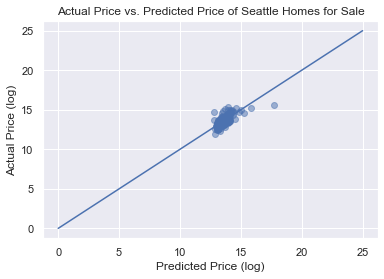

In [448]:
#ridge regularization doesn't seem to be increasing R2 score or decreasing MSE by a significant amount

ridge = Ridge(alpha = 1) 
ridge.fit(Xsa, ysa)
ys_pred_r = cross_val_predict(ridge, Xs, ys, cv=10)

#plot of y-actual vs. y-predicted after ridge regularization, for regularization alpha(lambda) = 1
plt.scatter(ys_pred_r, ys, alpha=.5);
plt.title('Actual Price vs. Predicted Price of Seattle Homes for Sale');
plt.xlabel('Predicted Price (log)');
plt.ylabel('Actual Price (log)');
plt.plot(np.linspace(0,25), np.linspace(0,25));

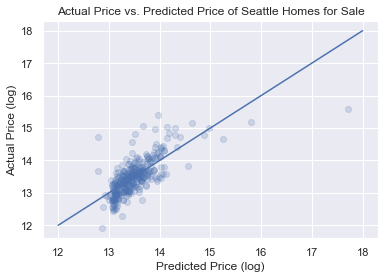

In [454]:
#the above plot zoomed in
#plot of y-actual vs. y-predicted after ridge regularization, for regularization alpha(lambda) = 1
plt.scatter(ys_pred_r, ys, alpha=.2);
plt.title('Actual Price vs. Predicted Price of Seattle Homes for Sale');
plt.xlabel('Predicted Price (log)');
plt.ylabel('Actual Price (log)');
plt.plot(np.linspace(12,18), np.linspace(12,18));
plt.savefig('seattlelog.png')
#outliers

Here we see the predicted price and actual price on a log scale alre fairly close. 
Now we undo the log transform and redo this plot, as well as calculate RMSE so price and error are in units of Dollars:

In [455]:
#undo log transform on y
ys_new = np.exp(ysa)

#ridge regularization doesn't seem to be increasing R2 score or decreasing MSE by a significant amount

ridge = Ridge(alpha = 1) 
ridge.fit(Xsa, ys_new)
ys_pred_r = cross_val_predict(ridge, Xs, ys_new, cv=10)

In [456]:
cv_ri_scores = cross_validate(ridge, Xs, ys_new, cv=10,
                        scoring=('r2','neg_mean_squared_error'), 
                        return_train_score=True)

print('Ridge, mean train r2:', np.mean(cv_ri_scores['train_r2']))
print('Ridge, mean test r2:', np.mean(cv_ri_scores['test_r2']), '\n')

#print('average train mse:', -(np.mean(cv_ri_scores['train_neg_mean_squared_error'])))
#print('average test mse', -(np.mean(cv_ri_scores['test_neg_mean_squared_error'])))

Ridge, mean train r2: 0.6344358853865862
Ridge, mean test r2: 0.46634325357996137 



In [457]:
tr_rmse = np.sqrt(-(np.mean(cv_ri_scores['train_neg_mean_squared_error'])))
te_rmse = np.sqrt(-(np.mean(cv_ri_scores['test_neg_mean_squared_error'])))

print('test rmse:', te_rmse)

test rmse: 412527.3821209022


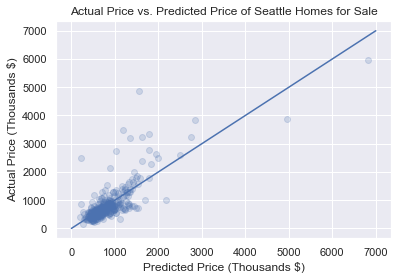

In [458]:
#plot of y-actual vs. y-predicted after ridge regularization, for regularization alpha(lambda) = 1
plt.scatter(ys_pred_r/1000, ys_new/1000, alpha=.2);
plt.title('Actual Price vs. Predicted Price of Seattle Homes for Sale');
plt.xlabel('Predicted Price (Thousands $)');
plt.ylabel('Actual Price (Thousands $)');
plt.plot(np.linspace(0,7000), np.linspace(0,7000));
plt.savefig('seattle.png')


As we can see, there are a few outliers, and model performance could be improved if we filter those out (didn't want to drop any rows at the beginning because dataset is fairly small).

As with the Vancouver dataset in Part 1, the next step would be to try to better understand the large MSE value (despite having a reasonable r2 value after log transformation of target (price). Scaling of the data could also be improved. Then we would perform feature engineering and regularize to see if we can improve r2. For both datasets it would be beneficial to get more rows and features, but we are fundamentally limited by what's allowed by the website at the moment.

_____________________

------